<a href="https://colab.research.google.com/github/RubenMcCarty/Master-BigData-DataScience/blob/main/DataScienceIris.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Importación de librerías



In [1]:
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, AffinityPropagation, MeanShift, estimate_bandwidth, SpectralClustering, AgglomerativeClustering, OPTICS, cluster_optics_dbscan, Birch, MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams

# 2. Carga del dataset

In [3]:
# dfIris = pd.read_csv("sample_data/IRIS.csv")
dfIris = pd.read_csv("IRIS.csv")

In [4]:
dfIris.shape

(150, 5)

In [5]:
dfIris.columns

Index(['sepal_length', 'sepal_width', 'petal_length', 'petal_width',
       'species'],
      dtype='object')

In [6]:
dfIris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [7]:
dfIris.tail()

,sepal_length,sepal_width,petal_length,petal_width,species
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


Duplicamos el dataset para no perder los datos originales:

In [8]:
dfIrisPreprocess = dfIris

# 3. Creación de los conjuntos de validación

La creación de los conjuntos de entrenamiento (train) y test se suelen hacer justo cuando los elementos han sido cargados y antes de que vayan a sufrir cambios.

**Esta decisión es útil ya que nos aseguramos de no estar contaminando nuestro criterio para una posterior validación.**

In [21]:
df_train, df_test = train_test_split(dfIris, test_size=0.2, stratify=dfIris['species'])

# 4. Selección, preprocesamiento y transformación

## 4.1 Detección de tipos de datos e incorporación de nuevas columnas

In [24]:
dfIris.dtypes

sepal_length    float64
sepal_width     float64
petal_length    float64
petal_width     float64
species          object
dtype: object

In [25]:
map_target_class = {'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}

df_train['species_numerical'] = df_train['species'].map(map_target_class)
df_test['species_numerical'] = df_test['species'].map(map_target_class)

df_train.head()

,sepal_length,sepal_width,petal_length,petal_width,species,species_numerical
88,5.6,3.0,4.1,1.3,Iris-versicolor,1
107,7.3,2.9,6.3,1.8,Iris-virginica,2
39,5.1,3.4,1.5,0.2,Iris-setosa,0
137,6.4,3.1,5.5,1.8,Iris-virginica,2
131,7.9,3.8,6.4,2.0,Iris-virginica,2


## 4.2. Reducción de la dimensionalidad

En este punto se debería realizar una selección de variables, por ejemplo, filtrar las variables que tengan una baja varianza, realizar pruebas de dependencia (también llamadas pruebas estadísticas univariadas), filtrar aquellas variables con alta correlación, etc. **Además, se deberían filtrar aquellas columnas que no encajen con nuestro objetivo del estudio.**

Para la **reducción de la dimensionalidad a nivel de filas** existen técnicas matemáticas, que nos pueden ayudar a detectar que variables aportan poca información. Algunas de las técnicas matemáticas más utilizadas son:

*   Lineales: PCA, análisis de discriminante lineal, análisis factorial, etc.
*   No lineales: t-SNE, ISOMAP, UMAP, escala multidimensional, etc.

A continuación, os voy a enseñar como se realizaría un PCA en el que, a través de una proyección con 2 componentes, intenten capturar la mayor parte de la varianza entre las 4 columnas iniciales que existen en el dataset.

In [26]:
X_train = df_train.drop(['species', 'species_numerical'], axis=1)
y_train = df_train['species_numerical']
X_test  = df_test.drop(['species', 'species_numerical'], axis=1)
y_test  = df_test['species_numerical']

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))

[0.92286526 0.05402279]
0.97688804738626


Vemos que el 98% de la varianza del problema puede ser explicado por estas dos nuevas variables que son combinación lineal de las 4 variables del problema.

<ipython-input-27-e065c12c28e2>:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=pca_df, x='PC1', y='PC2', c=y_train, palette='tab10')


<Axes: xlabel='PC1', ylabel='PC2'>

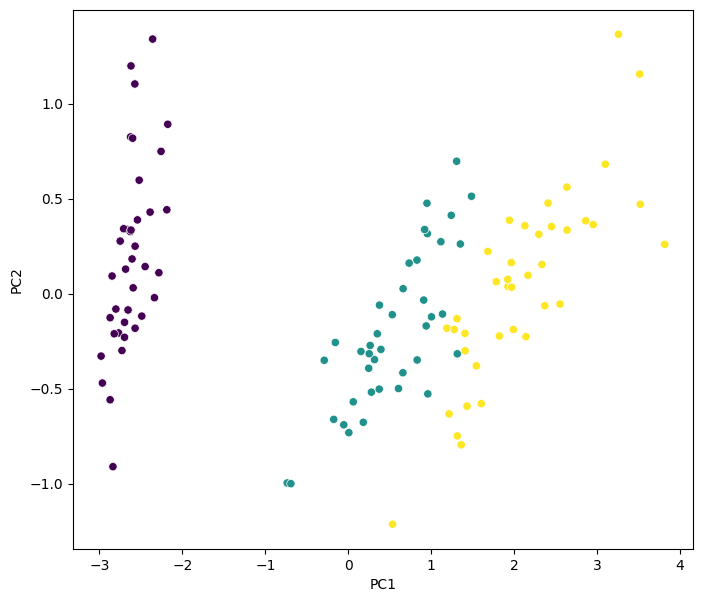

In [27]:
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['target'] = y_train

plt.figure(figsize=(8, 7))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', c=y_train, palette='tab10')

Vemos una clara separación entre los 3 clusters incluso habiendo reducido el problema a dos variables. Debajo vemos la comparativa y los resultados son muy buenos. Pensar que estamos perdiendo la mitad de los datos y aún así estamos conservando un score muy alto.

In [55]:
lr = LogisticRegression(random_state=101, max_iter=1000)
lr.fit(X_pca, y_train)
train_preds = lr.predict(X_pca)
print(classification_report(y_train, train_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       0.95      0.97      0.96        40
           2       0.97      0.95      0.96        40

    accuracy                           0.97       120
   macro avg       0.98      0.97      0.97       120
weighted avg       0.98      0.97      0.97       120



In [56]:
X_test_pca = pca.transform(X_test)
test_predictions = lr.predict(X_test_pca)
print(classification_report(y_test, test_predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.80      0.89        10
           2       0.83      1.00      0.91        10

    accuracy                           0.93        30
   macro avg       0.94      0.93      0.93        30
weighted avg       0.94      0.93      0.93        30



A medida que el número de componentes aumenta, veamos que sucede con la varianza.
*   **Varianza igual a 1:** Una varianza de 1 indica que, en promedio, los valores de un conjunto de datos se desvían en una unidad del promedio (media) de esos datos. Esto es común en los datos que han sido normalizados o estandarizados, donde la varianza de 1 es parte del proceso de estandarización. En este contexto, indica una dispersión estándar de los datos en torno a la media.

*   **Varianza igual a 0:** Una varianza de 0 significa que todos los valores en un conjunto de datos son idénticos. No hay dispersión ni variabilidad entre los valores. Todos los valores son iguales a la media. En la práctica, una varianza de 0 es rara en datos reales, pero puede ocurrir en conjuntos de datos muy uniformes o en situaciones controladas.

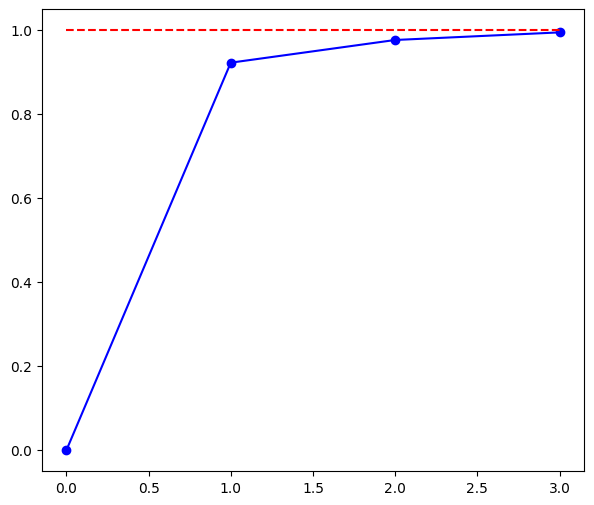

In [30]:
expl_var = [0]

for n_components in [1, 2, 3]:
    var_pca = PCA(n_components=n_components)
    X_pca_n = var_pca.fit_transform(X_train)
    expl_var.append(sum(var_pca.explained_variance_ratio_))

plt.figure(figsize=(7, 6))
plt.plot([0, 1, 2, 3], expl_var, 'bo-')
plt.plot([0, 3], [1, 1], 'r--')

En definitiva, la combinación lineal de las 4 variables del conjunto de datos utilizando un PCA y la varianza tan elevada explican que se mantiene la variabilidad del conjunto de datos.

## 4.3. Tratamiento de valores nulos

Para detectar valores nulos se puede hacer de la siguiente manera:

In [57]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117 entries, 88 to 94
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal_length       117 non-null    float64
 1   sepal_width        117 non-null    float64
 2   petal_length       117 non-null    float64
 3   petal_width        117 non-null    float64
 4   species            117 non-null    object 
 5   species_numerical  117 non-null    int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 6.4+ KB


O también se puede hacer de esta:

In [58]:
for column in df_train.columns:
    num_nulls = df_train[column].isna().sum()
    print(f'Column "{column}" has {num_nulls} nulls')

Column "sepal_length" has 0 nulls
Column "sepal_width" has 0 nulls
Column "petal_length" has 0 nulls
Column "petal_width" has 0 nulls
Column "species" has 0 nulls
Column "species_numerical" has 0 nulls


En este caso, no existen valores nulos en este conjunto de datos. Sin embargo, vamos a forzar el dataset para que contengan valores nulos y podamos tratarlos.

**IMPORTANTE: No ejecutar los códigos fuentes después de aquí si lo que se pretende es seguir con el proceso de análisis de datos en la siguiente sección. Recordad que el siguiente código fuente es a modo de prueba para que contempléis como se eliminarían valores nulos.**

En primer lugar, voy a forzar el dataset para que contengan valores nulos:

In [59]:
import random
indexes = random.sample(range(150), 15)

for index in indexes:
    if index > 80:
        df_train.iloc[index, 1] = np.nan
    else:
        df_train.iloc[index, 2] = np.nan

df_train.iloc[indexes]

IndexError: ignored

Observamos cuantos valores nulos tiene cada columna:

In [35]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120 entries, 88 to 94
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal_length       120 non-null    float64
 1   sepal_width        120 non-null    float64
 2   petal_length       116 non-null    float64
 3   petal_width        120 non-null    float64
 4   species            120 non-null    object 
 5   species_numerical  120 non-null    int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 10.6+ KB


In [36]:
for column in df_train.columns:
    num_nulls = df_train[column].isna().sum()
    print(f'Column "{column}" has {num_nulls} nulls')

Column "sepal_length" has 0 nulls
Column "sepal_width" has 0 nulls
Column "petal_length" has 4 nulls
Column "petal_width" has 0 nulls
Column "species" has 0 nulls
Column "species_numerical" has 0 nulls


Comprobamos que en el conjunto de test no existen valores nulos:

In [37]:
for column in df_test.columns:
    num_nulls = df_test[column].isna().sum()
    print(f'Column "{column}" has {num_nulls} nulls')

Column "sepal_length" has 0 nulls
Column "sepal_width" has 0 nulls
Column "petal_length" has 0 nulls
Column "petal_width" has 0 nulls
Column "species" has 0 nulls
Column "species_numerical" has 0 nulls


Una vez que detectamos que los valores nulos se encuentran en sepal_width y petal_length hay cuatro prácticas tradicionales para el tratamiento de valores nulos:

1.   Eliminar las columnas que contengan nulos.
2.   Quitar las filas que tienen nulos.
3.   Modificar por la media de la columna.
4.   Modificar con IterativeImputer de sklearn.



**Primera solución: Eliminar las columnas que contengan nulos:**

In [38]:
df_train.info()
df_train.drop(['sepal_width', 'petal_length'], axis=1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120 entries, 88 to 94
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal_length       120 non-null    float64
 1   sepal_width        120 non-null    float64
 2   petal_length       116 non-null    float64
 3   petal_width        120 non-null    float64
 4   species            120 non-null    object 
 5   species_numerical  120 non-null    int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 10.6+ KB


,sepal_length,petal_width,species,species_numerical
88,5.6,1.3,Iris-versicolor,1
107,7.3,1.8,Iris-virginica,2
39,5.1,0.2,Iris-setosa,0
137,6.4,1.8,Iris-virginica,2
131,7.9,2.0,Iris-virginica,2
...,...,...,...,...
25,5.0,0.2,Iris-setosa,0
140,6.7,2.4,Iris-virginica,2
95,5.7,1.2,Iris-versicolor,1
89,5.5,1.3,Iris-versicolor,1


**Segunda solución: Eliminar las filas que tienen nulos:**

In [39]:
df_train.dropna(subset=['sepal_width', 'petal_length'])

,sepal_length,sepal_width,petal_length,petal_width,species,species_numerical
88,5.6,3.0,4.1,1.3,Iris-versicolor,1
107,7.3,2.9,6.3,1.8,Iris-virginica,2
39,5.1,3.4,1.5,0.2,Iris-setosa,0
137,6.4,3.1,5.5,1.8,Iris-virginica,2
131,7.9,3.8,6.4,2.0,Iris-virginica,2
...,...,...,...,...,...,...
25,5.0,3.0,1.6,0.2,Iris-setosa,0
140,6.7,3.1,5.6,2.4,Iris-virginica,2
95,5.7,3.0,4.2,1.2,Iris-versicolor,1
89,5.5,2.5,4.0,1.3,Iris-versicolor,1


**Tercera solución: Modificar por la media de la columna**

In [40]:
media_sepal = df_train['sepal_width'].mean()
media_petal = df_train['petal_length'].mean()

df_train.loc[df_train['sepal_width'].isna(), 'sepal_width'] = media_sepal
df_train.loc[df_train['petal_length'].isna(), 'petal_length'] = media_petal

*¿Pensáis que es mejor reemplazar la media? ¿La mediana? ¿La moda?...*

**Cuarta solución: Modificar con IterativeImputer de sklearn (se debe ejecutar fuera de Google Colab)**

In [42]:
from sklearn.impute import IterativeImputer

imputer = IterativeImputer()
imputer.fit_transform(df_train)

ImportError: ignored

Volvemos a ejecutar el dataset para observar si se han eliminado los valores nulos:

In [43]:
for column in df_train.columns:
    num_nulls = df_train[column].isna().sum()
    print(f'Column "{column}" has {num_nulls} nulls')

Column "sepal_length" has 0 nulls
Column "sepal_width" has 0 nulls
Column "petal_length" has 0 nulls
Column "petal_width" has 0 nulls
Column "species" has 0 nulls
Column "species_numerical" has 0 nulls


## 4.4. Tratamiento de valores duplicados

Primero buscaremos los valores repetidos en el dataframe. Esto podemos hacerlo con el método duplicated(). Este método devuelve una serie de True/False (duplicado / no duplicado). Si le pasamos eso al DataFrame original, es como si estuvieramos filtrando por los valores que están duplicados.

El método duplicated por defecto borra el primer elemento repetido, pero como nos interesa ver todos los elementos, le pasamos el argumento "keep" como False, lo que significa que queremos ver todos los valores repetidos.

In [44]:
df_train[df_train.duplicated(keep=False)]

,sepal_length,sepal_width,petal_length,petal_width,species,species_numerical
142,5.8,2.7,5.1,1.9,Iris-virginica,2
34,4.9,3.1,1.5,0.1,Iris-setosa,0
37,4.9,3.1,1.5,0.1,Iris-setosa,0
9,4.9,3.1,1.5,0.1,Iris-setosa,0
101,5.8,2.7,5.1,1.9,Iris-virginica,2


In [45]:
df_train.shape

(120, 6)

In [46]:
df_train = df_train.drop_duplicates()

In [47]:
df_train.shape

(117, 6)

Comprobamos si en test también existen duplicados:

In [48]:
df_test[df_test.duplicated(keep=False)]

,sepal_length,sepal_width,petal_length,petal_width,species,species_numerical


## 4.5. Análisis univariante

### 4.5.1. Análisis univariante de la columna sepal_length

<Axes: xlabel='sepal_length', ylabel='Count'>

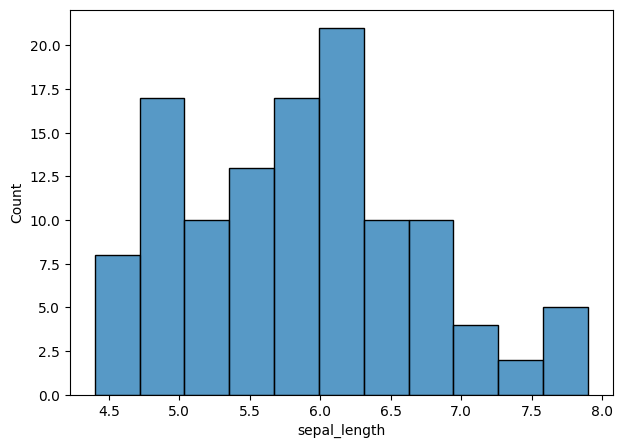

In [49]:
plt.figure(figsize=(7, 5))
sns.histplot(data=df_train, x='sepal_length', bins=11)

La distribución de esta variable no es exactamente normal. De hecho tiene forma de campana con una cola pesada y que los valores se encuentran entre 5 y 6.5.

### 4.5.2. Análisis univariante de la columna sepal_width

<Axes: xlabel='sepal_width', ylabel='Count'>

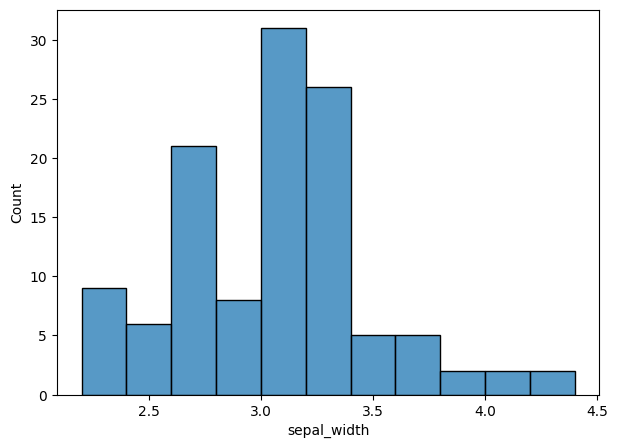

In [50]:
plt.figure(figsize=(7, 5))
sns.histplot(data=df_train, x='sepal_width', bins=11)

Vemos en el gráfico que esta variable tiene un comportamiento mucho más similar a una distribución normal.

### 4.5.3. Análisis univariante de la columna petal_length

<Axes: xlabel='petal_length', ylabel='Count'>

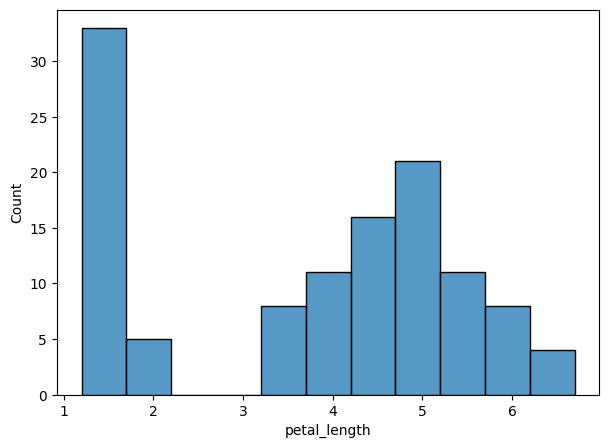

In [51]:
plt.figure(figsize=(7, 5))
sns.histplot(data=df_train, x='petal_length', bins=11)

Tiene una alta concentración de valores al principio, pero luego se comporta como una distribución normal.

### 4.5.4. Análisis univariante de la columna petal_width

<Axes: xlabel='petal_width', ylabel='Count'>

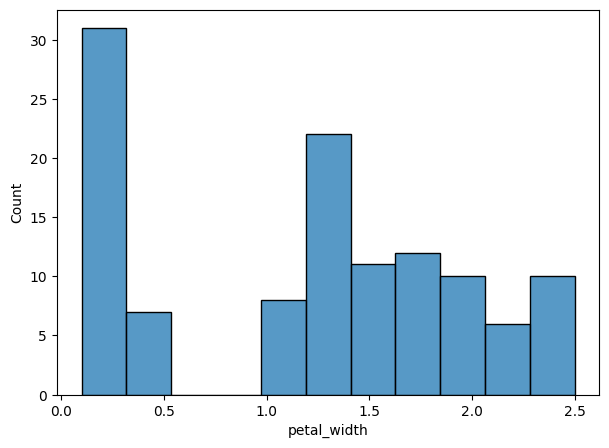

In [52]:
plt.figure(figsize=(7, 5))
sns.histplot(data=df_train, x='petal_width', bins=11)

Muy parecida a petal_length pero si es cierto que no sigue una distribución tan normal como petal_length.

En definitiva, tenemos:

*   sepal_length: Distribución casi-normal.
*   sepal_width: Distribución normal.
*   petal_length: No existe una distribución normal.
*   petal_width: No existe una distribución normal.

Dependiendo de si la técnica de minería de datos a utilizar es sensible a la escala y distribución de las características, deberíamos tener en cuenta que **es posible que tengamos que aplicar una transformación logarítimica** para aquellas columnas que no sigan una distribución normal o, incluso, para todo el conjunto de datos. La transformación logarítmica es útil para normalizar datos, reducir sesgos, y estabilizar la varianza.

**Esta toma de decisión afecta principalmente al preprocesamiento.** Por este motivo, y porque no queremos modificar los datos del conjunto de datos ya que vamos a seguir realizando análisis bivariantes y multivariantes, la decisión de realizar una transformación logarítimica la pospondremos para secciones posteriores.


Ahora vamos a observar la distribución que existe entre las diferentes clases que existen en el conjunto de datos.

<Axes: xlabel='species', ylabel='count'>

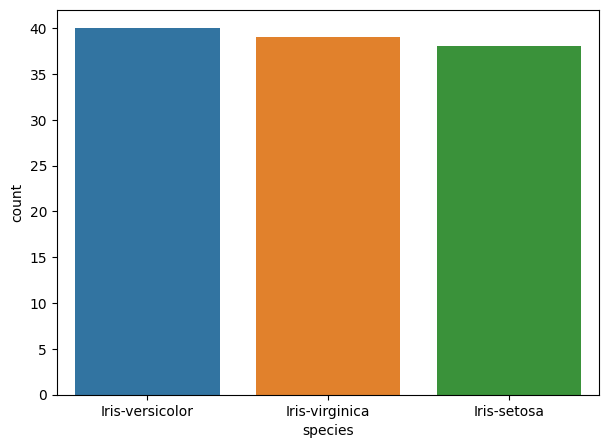

In [53]:
plt.figure(figsize=(7, 5))
sns.countplot(data=df_train, x='species')

Cuando se trata de aprendizaje supervisado y más aún, para tareas de clasificación, regresión y predicción lo ideal es que las clases se encuentren balanceadas. En este caso, todas las clases tienen la misma representación, que es el caso ideal.

En el caso de clases desbalanceadas, hay que rebalancear las clases para que nuestro modelo pueda aprender suficiente de cada clase y no priorizar una sobre otra, o incluso predecir siempre una si el desbalance es muy grande.

## 4.6. Análisis bivariante

Como las 4 variables independientes son numéricas, podemos utilizar pairplot de Seaborn. Sin embargo, si debemos estudiar muchas variables es posible que antes tengamos que hacer un estudio de correlación que nos permita quitarnos algunas variables, y solo analizar las variables relevantes y/o correlacionadas.

En este caso vamos a coger las 4 columnas de sepal_length, sepal_width, petal_length y petal_width. El resto de columnas (clase y clase_numérica) no se contemplarán.

In [54]:
df_train.iloc[:,:4]

,sepal_length,sepal_width,petal_length,petal_width
88,5.6,3.0,4.1,1.3
107,7.3,2.9,6.3,1.8
39,5.1,3.4,1.5,0.2
137,6.4,3.1,5.5,1.8
131,7.9,3.8,6.4,2.0
...,...,...,...,...
25,5.0,3.0,1.6,0.2
140,6.7,3.1,5.6,2.4
95,5.7,3.0,4.2,1.2
89,5.5,2.5,4.0,1.3


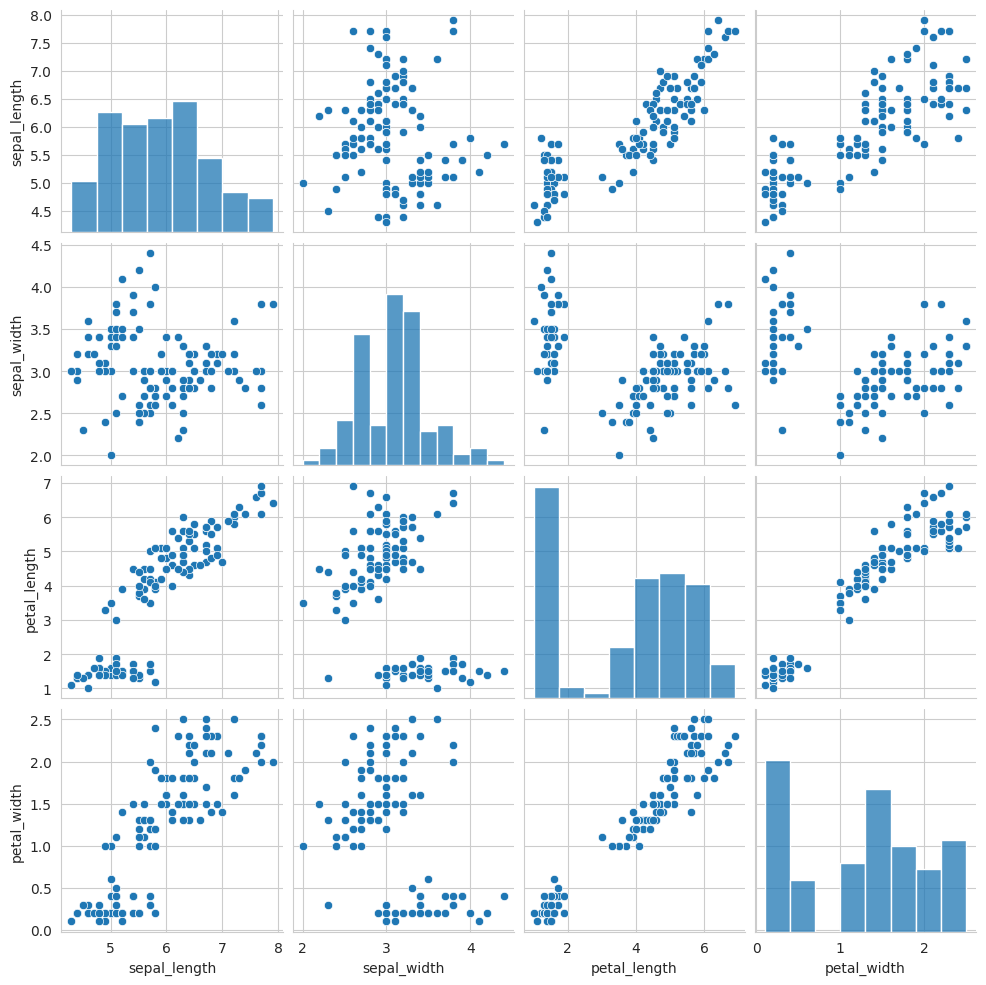

In [ ]:
sns.pairplot(df_train.iloc[:,:4])

Las variables petal_length y petal_width están bastante correlacionadas, y lo mismo se ve para petal_length y sepal_length.

## 4.7. Análisis multivariante



Podemos introducir una variable más a este proceso, que será la variable a predecir "species". Podemos hacerlo introduciendo un hue en el pairplot para ver si podemos visualizar rápidamente alguna frontera de separación entre las 3 especies de flores.


<Figure size 700x700 with 0 Axes>

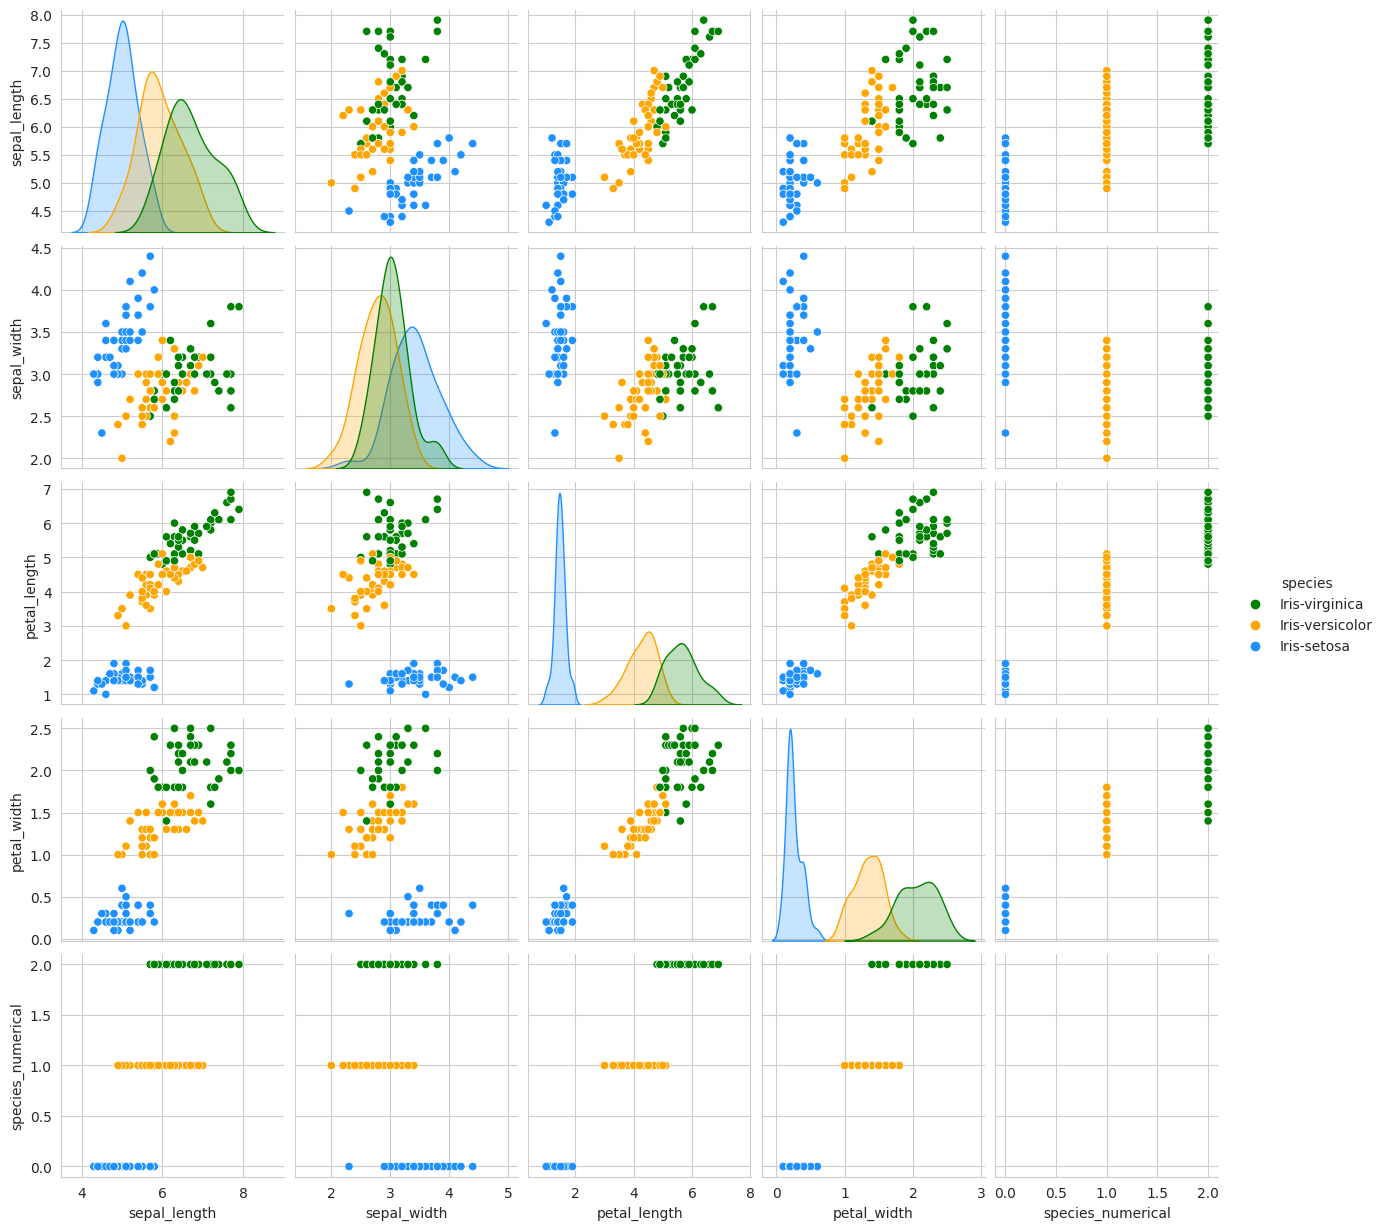

In [ ]:
plt.figure(figsize=(7,7))
sns.set_style('whitegrid')
sns.pairplot(data=df_train, hue='species', palette=['green','orange','dodgerblue'])

Vemos que existe una frontera de separación entre los datos, por lo que es probable que nuestro problema sea capaz de resolverlo de forma analítica y llegando a un buen resultado.

## 4.8. Análisis de correlación

A pesar de que el análisis de correlación es indispensable para variables numéricas, y sobretodo para modelos lineales, se debe revisar siempre. En este punto, debemos detectar la correlación entre variables ya que debemos evitar a toda costa variables con correlación alta, porque significa que están introduciendo problemas al modelo que luego entrenaremos para resolver el problema.

Algunos errores comunes que se cometen en el análisis de correlación:

* Incluir variables categóricas: La correlación de Pearson se calcula como el ratio entre la covarianza entre dos variables y la raíz del producto de sus varianzas. Esto significa que las variables que utilicemos en el análisis de correlación deberán ser continuas.
* No definir la escala correcta: La correlación está entre 0 y 1, pero muchas veces cuando se obtiene la gráfica veremos que la escala de colores se ajusta al valor mínimo y máximo de nuestra escala y no al rango [0,1]. Hay que forzar a la gráfica para que el rango de colores se muestre en base al rango y no a la escala de mínimo y máximo.
* Tomar correlación "buena" o "mala" basado en un número arbitrario: Muchas veces veremos declaraciones como "correlación por encima de 0.7 es muy alta" o lo contrario. En la realidad debemos apoyarnos en el gráfico y el valor de la correlación a la vez para poder tomar una decisión más acertada.
* No graficar los valores de la correlación sobre los gráficos en el heatmap: Los valores ayudar a resolver esas diferencias en las que no estamos seguros de si lo que vemos es una correlación muy alta o regular. Para esto le pasaremos al heatmap el parámetro annot=True

<Axes: >

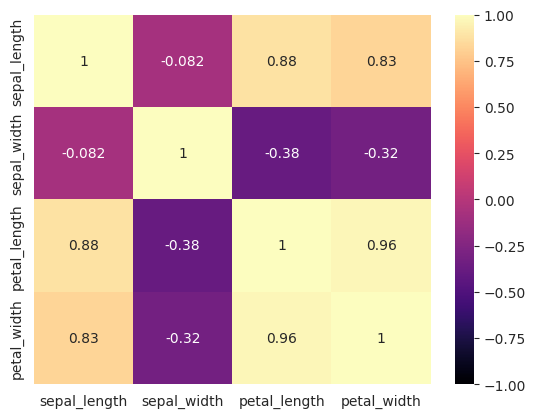

In [ ]:
sns.heatmap(df_train.iloc[:,:4].corr(), vmin=-1, vmax=1, cmap='magma', annot=True)

Se ve claramente que la correlación entre petal_length y sepal_length y la de petal_length y petal_width es alta, como habíamos visto en los demás análisis. Esto confirma nuestra teoría.

## 4.9. Preprocesamiento

Como se dijo anteriormente, se requiere realizar una transformación de los datos para que las distribuciones del conjunto de datos sea normal. Para ello, se realizará una normalización del conjunto de datos a través de StandardScaler() de sklearn.

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

## 4.10. Opcional: Comprobación de generalización (aprendizaje supervisado + validación)

In [ ]:
lr = LogisticRegression(random_state=101, max_iter=1000)
lr.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=101)

In [ ]:
preds_train = lr.predict(X_train)
print(confusion_matrix(y_train, preds_train))
print(classification_report(y_train, preds_train))

[[40  0  0]
 [ 0 38  2]
 [ 0  2 38]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       0.95      0.95      0.95        40
           2       0.95      0.95      0.95        40

    accuracy                           0.97       120
   macro avg       0.97      0.97      0.97       120
weighted avg       0.97      0.97      0.97       120



La precisión del resultado es altísima. Esto es obvio ya que habíamos visto que es posible obtener una frontera de separación bastante buena simplemente con mirar el problema, por lo que era bastante probable que nuestro algoritmo de regresión logística fue capaz de devolver un resultado muy bueno.

Sin embargo, sólo hemos validado con el conjunto con el que hemos entrenado el modelo. Debemos entender que no hemos medido cómo es el desempeño de nuestro modelo con nuevos datos... (metemos los datos del conjunto de test)

In [ ]:
preds = lr.predict(X_test)
print(confusion_matrix(y_test, preds))
print(classification_report(y_test, preds))

[[10  0  0]
 [ 0 10  0]
 [ 0  2  8]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.83      1.00      0.91        10
           2       1.00      0.80      0.89        10

    accuracy                           0.93        30
   macro avg       0.94      0.93      0.93        30
weighted avg       0.94      0.93      0.93        30



Vemos que nuestro modelo es igual de bueno con datos que jamás ha visto. Por lo que podemos decir que el modelo parece generalizar bien en nuestro dataset.

# 5. Minería de datos

kkk